## SciBERT is a BERT model trained on scientific text.

* SciBERT is trained on papers from the corpus of semanticscholar.org. Corpus size is 1.14M papers, 3.1B tokens 
 
* It is trained on the full text of the papers in training,and not just abstracts

* It has its own vocabulary (scivocab) that's built to best match the training corpus

The following is an implementation of SciBert via TensorFlow2

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/researchtopictags/train.csv
/kaggle/input/researchtopictags/sample.csv
/kaggle/input/researchtopictags/test.csv
/kaggle/input/researchtopictagaugwithoutlatextags/train_aug_without_latex_tags.csv
/kaggle/input/researchtopictagaugwithoutlatextags/sample.csv
/kaggle/input/researchtopictagaugwithoutlatextags/test_aug_without_latex_tags.csv
/kaggle/input/researchtopictagaug/test_aug_with_latex_tags.csv
/kaggle/input/researchtopictagaug/sample.csv
/kaggle/input/researchtopictagaug/train_aug_with_latex_tags.csv
/kaggle/input/researchtopictagwithoutlatex/train_without_latex_tags.csv
/kaggle/input/researchtopictagwithoutlatex/test_without_latex_tags.csv
/kaggle/input/researchtopictagwithoutlatex/sample.csv


In [2]:
!pip install -q transformers==2.11.0
!wget https://s3-us-west-2.amazonaws.com/ai2-s2-research/scibert/tensorflow_models/scibert_scivocab_uncased.tar.gz
!tar -xvf ./scibert_scivocab_uncased.tar.gz

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
--2020-08-23 17:58:34--  https://s3-us-west-2.amazonaws.com/ai2-s2-research/scibert/tensorflow_models/scibert_scivocab_uncased.tar.gz
Resolving s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)... 52.218.204.136
Connecting to s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)|52.218.204.136|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1216161420 (1.1G) [application/x-tar]
Saving to: ‘scibert_scivocab_uncased.tar.gz’

scibert_scivocab_un 100%[===================>]   1.13G  52.6MB/s    in 21s     

2020-08-23 17:58:55 (55.5 MB/s) - ‘scibert_scivocab_uncased.tar.gz’ saved [1216161420/1216161420]

scibert_scivocab_uncased/
scibert_scivocab_uncased/bert_model.ckpt.data-00000-of-00001
scibert_scivocab_uncased/bert_model.ckpt.index
scibert_scivocab_uncased/vocab.txt
scibert_scivocab_uncased/bert_model.ckpt.meta
scibert_scivocab_uncased/bert_config.json

In [3]:
os.environ["WANDB_API_KEY"] = "0" ## to silence warning
!transformers-cli convert --model_type bert \
  --tf_checkpoint './scibert_scivocab_uncased/bert_model.ckpt' \
  --config './scibert_scivocab_uncased/bert_config.json' \
  --pytorch_dump_output './scibert_scivocab_uncased/pytorch_model.bin'

2020-08-23 17:59:17.388992: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
Building PyTorch model from configuration: BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "type_vocab_size": 2,
  "vocab_size": 31090
}

Save PyTorch model to ./scibert_scivocab_uncased/pytorch_model.bin


In [4]:
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
import seaborn as sns
import tensorflow as tf

from transformers import BertTokenizer ,BertConfig
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

from transformers import TFBertModel
from tensorflow.keras.layers import Dense, Flatten

import time
from transformers import create_optimizer
import transformers

print('transformers version :', transformers.__version__)

transformers version : 2.11.0


# The model has been trained on 4 modifications of data:

* Original
* Original without Latex Tags
* Augmented Data(Translate + De-Translate)
* Augmented Data - without Latex Tags


The details can bee found out in this notebook https://www.kaggle.com/gcspkmdr/text-data-augmentation-latex-tag-translate/edit

In [5]:
train_data = pd.read_csv('../input/researchtopictagaug/train_aug_with_latex_tags.csv')
print(train_data.shape)
train_data.head()

(20972, 9)


,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,Reconstruction of subject-specific effect maps,Predictive models allow subject-specific infer...,1,0,0,0,0,0
1,2,Rotational invariance neural network,The rotational invariance and the translationa...,1,0,0,0,0,0
2,3,Spherical polyharmonics and Poisson's kernel f...,We introduce and develop the notion of spheric...,0,0,1,0,0,0
3,4,A finite element approximation for the Maxwell...,The Landau - Lifshitz - Gilbert (LLG) stochast...,0,0,1,0,0,0
4,5,Comparative study of discrete wavelet transfor...,Infrared Fourier Transform (FTIR) spectra of s...,1,0,0,1,0,0


In [6]:
train_data = train_data.drop(train_data.index[16394])

In [7]:
test_data = pd.read_csv('../input/researchtopictagaug/test_aug_with_latex_tags.csv')
print(test_data.shape)
test_data.head()

(8989, 3)


,ID,TITLE,ABSTRACT
0,20973,Marginal likelihood in closed form with the Ga...,We present novel insights into the Gamma-Poiss...
1,20974,Average infrared laboratory spectra of balance...,Meteorites contain minerals from asteroids of ...
2,20975,Case of AMSDU static aggregation in WLANs,Frame aggregation is a mechanism by which mult...
3,20976,The $ Gaia $ -ESO Survey: The NGC 6802 Interna...,The open clusters of the Milky Way are very di...
4,20977,Witness functions versus interpretation functi...,Proving that a cryptographic protocol is corre...


In [8]:
train_data['combined_text'] = train_data['TITLE'] + " <join> " + train_data['ABSTRACT']
test_data['combined_text'] = test_data['TITLE'] + " <join> " + test_data['ABSTRACT']

In [9]:
label_cols = ['Computer Science','Physics','Mathematics', 'Statistics','Quantitative Biology','Quantitative Finance']

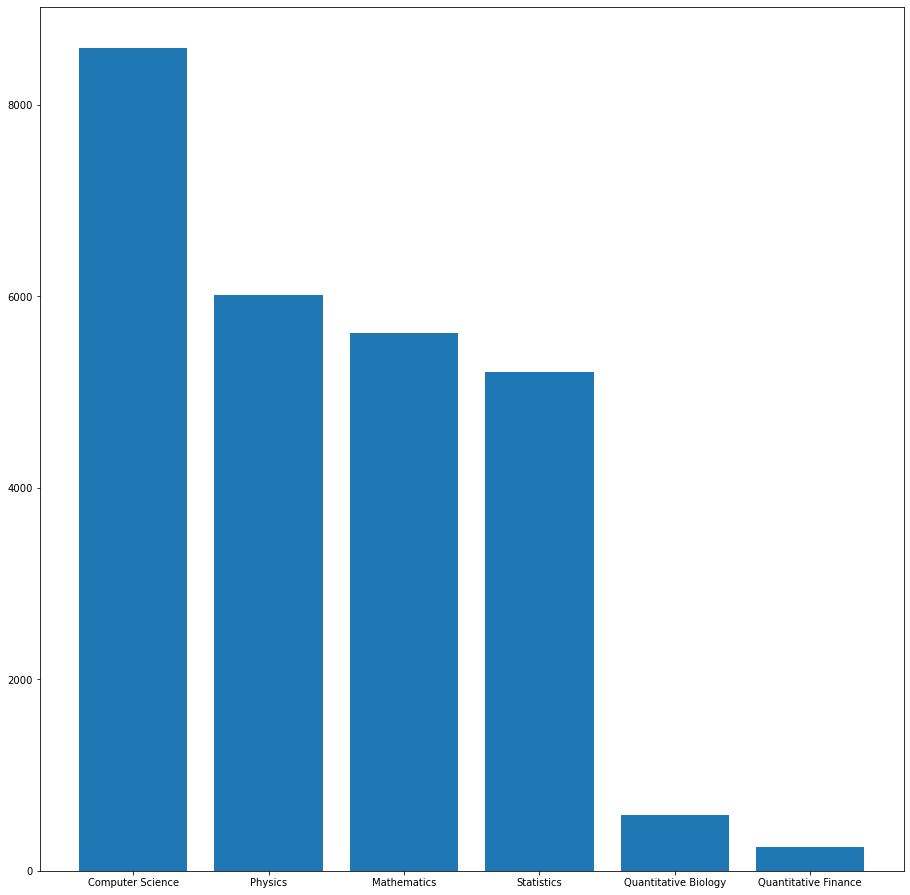

In [10]:
com_sc = train_data['Computer Science'].value_counts()[1]

phy = train_data['Physics'].value_counts()[1]

mat = train_data['Mathematics'].value_counts()[1]

stats = train_data['Statistics'].value_counts()[1]

bio = train_data['Quantitative Biology'].value_counts()[1]

fin = train_data['Quantitative Finance'].value_counts()[1]

fig = plt.figure()

ax = fig.add_axes([0,0,1,1])

counts = [com_sc,phy,mat,stats,bio,fin]

ax.bar(label_cols,counts)

plt.show()

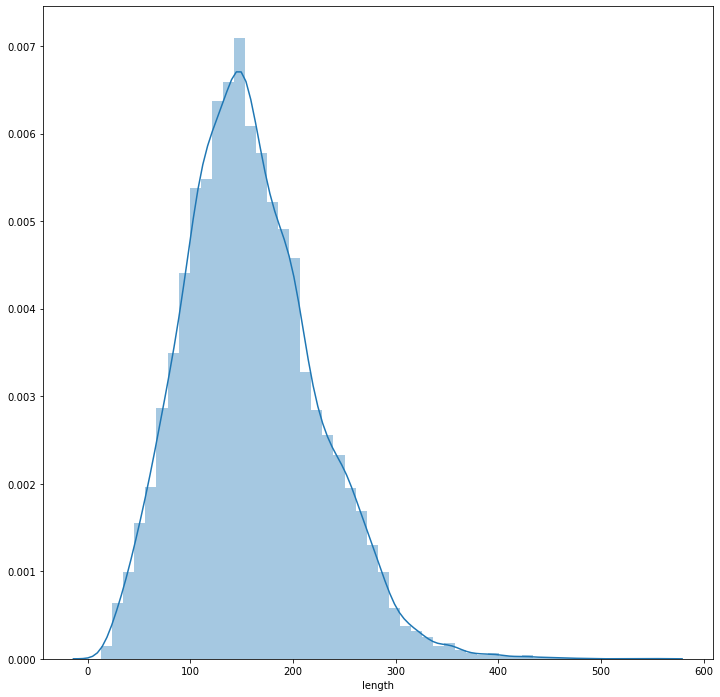

In [11]:
train_data['length'] = train_data['combined_text'].apply(lambda x : x.count(" ") + 1)

sns.distplot(train_data['length'])

In [12]:
# Parameters

BATCH_SIZE = 8

TEST_BATCH_SIZE = 8

NR_EPOCHS = 1

MAX_LEN = 300 # try diffrent lengths

threshold = 0.4

bert_model_name = './scibert_scivocab_uncased'

config = BertConfig.from_json_file('./scibert_scivocab_uncased/bert_config.json')

# Tokenizer

In [13]:
tokenizer = BertTokenizer.from_pretrained(bert_model_name, do_lower_case=True)

def tokenize_sentences(sentences, tokenizer, max_seq_len = 128):
    
    tokenized_sentences = []

    for sentence in tqdm(sentences):
        
        tokenized_sentence = tokenizer.encode(sentence,                  
                                              add_special_tokens = True, 
                                              max_length = max_seq_len  
                                             )
        
        tokenized_sentences.append(tokenized_sentence)

    return tokenized_sentences

def create_attention_masks(tokenized_and_padded_sentences):
    
    attention_masks = []

    for sentence in tokenized_and_padded_sentences:
        
        att_mask = [int(token_id > 0) for token_id in sentence]
        
        attention_masks.append(att_mask)

    return np.asarray(attention_masks)

input_ids = tokenize_sentences(train_data['combined_text'], tokenizer, MAX_LEN)

input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", value=0, truncating="post", padding="post")

attention_masks = create_attention_masks(input_ids)

# SciBERT Classifier

In [14]:
class BertClassifier(tf.keras.Model):    
    
    def __init__(self, bert: TFBertModel, num_classes: int):
        
        super().__init__()
        
        self.bert = bert
        
        self.classifier = Dense(num_classes, activation='sigmoid')
        
    def call(self, input_ids, attention_mask=None, token_type_ids=None, position_ids=None, head_mask=None):
        
        outputs = self.bert(input_ids,
                            attention_mask=attention_mask,
                            token_type_ids=token_type_ids,
                            position_ids=position_ids,
                            head_mask=head_mask)
        
        cls_output = outputs[1]
        
        cls_output = self.classifier(cls_output)
                
        return cls_output

In [15]:
def create_dataset(data_tuple, batch_size, train=True):
    
    dataset = tf.data.Dataset.from_tensor_slices(data_tuple)
    
    dataset = dataset.repeat(1)
    
    if train:
        
        dataset = dataset.shuffle(buffer_size=10000)
    
    dataset = dataset.batch(batch_size)
    
    if train:
        
        dataset = dataset.prefetch(1)
        
    if not train:
        
        dataset = dataset.cache()
    
    return dataset


In [16]:
def create_test_dataset():
    
    test_input_ids = tokenize_sentences(test_data['combined_text'], tokenizer, MAX_LEN)
    
    test_input_ids = pad_sequences(test_input_ids, maxlen=MAX_LEN, dtype="long", value=0, truncating="post", padding="post")
    
    test_attention_masks = create_attention_masks(test_input_ids)
    
    test_steps = len(test_data) // TEST_BATCH_SIZE
    
    test_dataset = create_dataset((test_input_ids, test_attention_masks), batch_size=TEST_BATCH_SIZE, train=False)
    
    return test_dataset

submission = pd.read_csv('../input/researchtopictagaug/sample.csv', index_col='ID')

def generate_class_probablities(model,test_dataset,test_steps):
    
    for i, (token_ids, masks) in enumerate(tqdm(test_dataset, total=test_steps)):
        
        sample_ids = test_data.iloc[i*TEST_BATCH_SIZE:(i+1)*TEST_BATCH_SIZE]['ID']
        
        predictions = model(token_ids, attention_mask=masks).numpy()
        
        submission.loc[sample_ids, label_cols] = predictions
    
    return submission.loc[:,label_cols].values

test_dataset = create_test_dataset()

test_steps = len(test_data) // TEST_BATCH_SIZE

class_probs = np.zeros(shape =(len(test_data),len(label_cols)))

In [17]:
#Gradient Calculation

def train_step(model, token_ids, masks, labels):
    
    labels = tf.dtypes.cast(labels, tf.float32)
    
    with tf.GradientTape() as tape:
        
        predictions = model(token_ids, attention_mask=masks)
        
        loss = loss_object(labels, predictions)
    
    
    gradients = tape.gradient(loss, model.trainable_variables)
    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables), name = 'gradients')
    
    train_loss(loss)

    for i, auc in enumerate(train_auc_metrics):
        
        auc.update_state(labels[:,i], predictions[:,i])
        
def validation_step(model, token_ids, masks, labels):
    
    labels = tf.dtypes.cast(labels, tf.float32)

    predictions = model(token_ids, attention_mask=masks, training=False)
    
    v_loss = loss_object(labels, predictions)

    validation_loss(v_loss)
    
    for i, auc in enumerate(validation_auc_metrics):
        
        auc.update_state(labels[:,i], predictions[:,i])                                    

In [18]:
#seeds = [0 ,31 ,97,193,1001,83,42,456,21,237] # for ensembles

seeds = [0]

for seed in range(len(seeds)):
    
    print('=' * 50, f"CV {seed+1}", '=' * 50)
    
    model = BertClassifier(TFBertModel.from_pretrained(bert_model_name, from_pt=True, config = config), len(label_cols))
    
    labels =  train_data[label_cols].values
    
    train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state=seed, test_size = 0.2)

    train_masks, validation_masks = train_test_split(attention_masks, random_state=seed, test_size=0.2)

    train_size = len(train_inputs)

    validation_size = len(validation_inputs)


    train_dataset = create_dataset((train_inputs, train_masks, train_labels), batch_size=BATCH_SIZE,train=True)

    validation_dataset = create_dataset((validation_inputs, validation_masks, validation_labels), batch_size=BATCH_SIZE,train=False)
    
    
    steps_per_epoch = train_size // (BATCH_SIZE)

    #  Loss Function
    loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=False)

    train_loss = tf.keras.metrics.Mean(name='train_loss')

    validation_loss = tf.keras.metrics.Mean(name='val_loss')

    #  Optimizer (with 1-cycle-policy)
    warmup_steps = steps_per_epoch // 3

    total_steps = steps_per_epoch * NR_EPOCHS - warmup_steps

    optimizer = create_optimizer(init_lr=2e-5, num_train_steps=total_steps, num_warmup_steps=warmup_steps)

    # Gradients
    
    gradients = 0
    
    #  Metrics
    train_auc_metrics = [tf.keras.metrics.AUC() for i in range(len(label_cols))]

    validation_auc_metrics = [tf.keras.metrics.AUC() for i in range(len(label_cols))]


    for epoch in range(NR_EPOCHS):

        print('=' * 50, f"EPOCH {epoch+1}", '=' * 50)

        start = time.time()


        for batch_no, (token_ids, masks, labels) in enumerate(tqdm(train_dataset)):

            train_step(model, token_ids, masks, labels)

            if batch_no % 100 == 0:

                    print(f'\nTrain Step: {batch_no}, Loss: {train_loss.result()}')

                    for i, label_name in enumerate(label_cols):

                        print(f"{label_name} roc_auc {train_auc_metrics[i].result()}")

                        train_auc_metrics[i].reset_states()

        for batch_no, (token_ids, masks, labels) in enumerate(tqdm(validation_dataset)):

            validation_step(model, token_ids, masks, labels)

        print(f'\nEpoch {epoch+1}, Validation Loss: {validation_loss.result()}, Time: {time.time()-start}\n')

        for i, label_name in enumerate(label_cols):

            print(f"{label_name} roc_auc {validation_auc_metrics[i].result()}")

            validation_auc_metrics[i].reset_states()

        print('\n')
        
    probs = generate_class_probablities(model,test_dataset,test_steps)
        
    submission.loc[:, label_cols] = probs
        
    submission.to_csv('probs'+str(seed)+'.csv')
        
    class_probs += probs

================================================== CV 1 ==================================================
================================================== EPOCH 1 ==================================================



Train Step: 0, Loss: 0.7942501306533813
Computer Science roc_auc 0.3125
Physics roc_auc 1.0
Mathematics roc_auc 1.0
Statistics roc_auc 0.8000000715255737
Quantitative Biology roc_auc 0.0
Quantitative Finance roc_auc 0.0

Train Step: 100, Loss: 0.6040513515472412
Computer Science roc_auc 0.587896466255188
Physics roc_auc 0.7829281091690063
Mathematics roc_auc 0.7216666340827942
Statistics roc_auc 0.542328953742981
Quantitative Biology roc_auc 0.5120849609375
Quantitative Finance roc_auc 0.6976553797721863

Train Step: 200, Loss: 0.45414483547210693
Computer Science roc_auc 0.8730979561805725
Physics roc_auc 0.945990800857544
Mathematics roc_auc 0.9188166856765747
Statistics roc_auc 0.8495171070098877
Quantitative Biology roc_auc 0.5815846920013428
Quantitative Finance roc_auc 0.2822025716304779

Train Step: 300, Loss: 0.37805864214897156
Computer Science roc_auc 0.9102733135223389
Physics roc_auc 0.9674248695373535
Mathematics roc_auc 0.9466093182563782
Statistics roc_auc 0.91895210742



Epoch 1, Validation Loss: 0.154645174741745, Time: 1102.5867094993591

Computer Science roc_auc 0.9555482864379883
Physics roc_auc 0.9825984835624695
Mathematics roc_auc 0.9649950265884399
Statistics roc_auc 0.9562990665435791
Quantitative Biology roc_auc 0.9656068682670593
Quantitative Finance roc_auc 0.9945358037948608




In [19]:
submission.loc[:, label_cols] = class_probs
    
submission.to_csv('probs_300.csv')

In [20]:
predictions = (class_probs/len(seeds) > threshold).astype(int)

submission.loc[:, label_cols] = predictions

submission.head()

,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
ID,,,,,,
20973,0,0,0,1,0,0
20974,0,1,0,0,0,0
20975,1,0,0,0,0,0
20976,0,1,0,0,0,0
20977,1,0,0,0,0,0


In [21]:
submission.to_csv('submission.csv')